In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ecotools.pi_client import pi_client

sns.set('paper')
# Option Paramater time_zone
# default timezone is time_zone='America/Los_Angeles' use https://www.iana.org/time-zones 

#pi = pi_client(username= r'ad3\username')
pi = pi_client(username = r'ad3\sbharadw')

Connecting to PI API using 'basic authentication'


In [3]:
tags = ['CCAH_ChilledWater_Demand_kBtu', 'aiTIT4045']

In [4]:
start = '2022-07-05'
end = '*'
interval = '1h' # Can be "min" "h" "d"
calculation = 'summary'
summary_calc = 'average'
weight = 'TimeWeighted'

df = pi.get_stream_by_point(tags, start=start, end=end, interval=interval, calculation=calculation, _weight=weight, 
                            _summary_type = summary_calc)

df.head()

10:47:34: Sending API request... Chunk 1 of 1
10:47:38: Response recieved for 2 tags! (3.04)


,CCAH_ChilledWater_Demand_kBtu,aiTIT4045
Timestamp,,
2022-07-05 00:00:00,1110.775996,72.262881
2022-07-05 01:00:00,1106.332959,72.216921
2022-07-05 02:00:00,1041.997232,70.612774
2022-07-05 03:00:00,1070.060387,69.756020
2022-07-05 04:00:00,1058.919854,69.406466


In [5]:
X = df.drop('CCAH_ChilledWater_Demand_kBtu', axis = 1).values
y = df['CCAH_ChilledWater_Demand_kBtu'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Random state ensures that the splits that you generate are reproducible. 
# Scikit-learn uses random permutations to generate the splits. 
# The random state that you provide is used as a seed to the random number generator.
# This ensures that the random numbers are generated in the same order.
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [6]:
X_train

tensor([[69.3336],
        [44.0852],
        [60.3666],
        ...,
        [55.3741],
        [74.5357],
        [58.6225]])

In [7]:
y_train

tensor([1081,   38,  396,  ...,   92, 1050,  173])

In [12]:
#ReLU for our activation function
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=16)
        self.fc2 = nn.Linear(in_features=16, out_features=12)
        self.output = nn.Linear(in_features=12, out_features=1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [13]:
#instance of the model and verify that its architecture matches the one we specified above
model = ANN()
model

ANN(
  (fc1): Linear(in_features=1, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=12, bias=True)
  (output): Linear(in_features=12, out_features=1, bias=True)
)

In [14]:
#Criterion: basically how we measure loss, we’ll use CrossEntropyLoss
#Optimizer: optimization algorithm, we’ll use Adam with a learning rate of 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [17]:
len(y_train)

7821

In [15]:
%%time

epochs = 100
loss_arr = []

for i in range(epochs):
    y_hat = model.forward(X_train)
    loss = criterion(y_hat, y_train)
    loss_arr.append(loss)
    
 
    if i % 10 == 0:
        print(f'Epoch: {i} Loss: {loss}')
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

IndexError: Target 1081 is out of bounds.

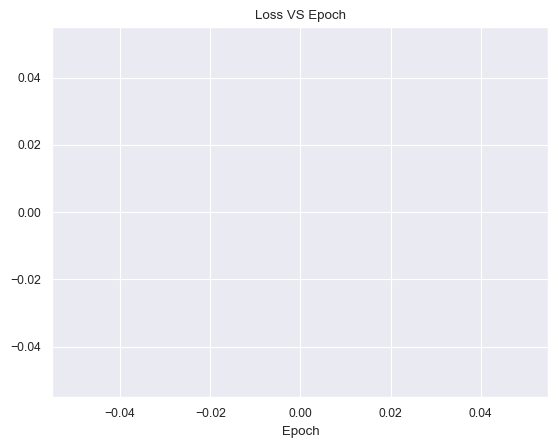

In [14]:
plt.title('Loss VS Epoch')
plt.xlabel("Loss")
plt.xlabel("Epoch")
plt.plot(loss_arr)